In [1]:
# Solve problem 6 from Lagaris, Likas, and Fotiadis (1998)
# $(x,y) \in [0,1]^2$
# $$ \Delta u(x,y) = f(x,y), where f(x,y) = (2-\pi^2y^2)sin(\pi x)$$
# Boundary conditions:
# u(0,y) = 0
# u(1,y) = 0
# u(x,0) = 0
# u(x,1) = 2\sin(\pi x)
# Exact solution: u_{ex}(x,y) = y^2\sin(\pi x)
# Solution model: u(x,y) = B(x,y) + x(1-x)y[NN(x,y;W)-N(x,1;W)-N_y(x,1;W)]
# where NN(x,y;W) is a neural network of the form NN(x,y) = v * sigma(W*[x,y]^T + v)
# where v is n-by-1, W is n-by-2, v is n-by-1,
# x(1-x)y is a function that is zero on the Dirichlet boundary, and 
# B(x,y) is a smooth function satisfying boundary conditions:
# B(x,y) = 2y\sin(\pi x)
# Training points: {(x_i,y_i)}_{i=1}^N
# loss function: L(w) = (1/N)\sum_{i=1}^N (u_{xx}(x_i,y_i) + u_{yy}(x_i,y_i) - f(x_i,y_i))^2

In [2]:
# import necessary packages
import numpy as np
import torch
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.float64) # set arithmetic to be double precision
plt.rcParams.update({'font.size': 20}) # set font size in all plots

In [3]:
# define the exact solution
def ExactSolution(x,y):
    # e^{-x}(x+y^3)
    return y.pow(2)*torch.sin(torch.pi*x)

In [4]:
def prepare_data(xmin,xmax,nx,ymin,ymax,ny,strip_bdry):
    x1 = torch.linspace(xmin,xmax,steps = nx)
    y1 = torch.linspace(ymin,ymax,steps = ny)
    if strip_bdry == True:
        grid_x, grid_y = torch.meshgrid(x1[1:nx-1],y1[1:ny-1],indexing = 'ij')
    else:
        grid_x, grid_y = torch.meshgrid(x1,y1,indexing = 'ij')
    xcol = torch.reshape(grid_x,(grid_x.numel(),1))
    ycol = torch.reshape(grid_y,(grid_y.numel(),1))
    data_matrix = torch.cat((xcol,ycol),1)
    return grid_x, grid_y, data_matrix

Text(0.5, 1.0, 'Exact sol. and train pts')

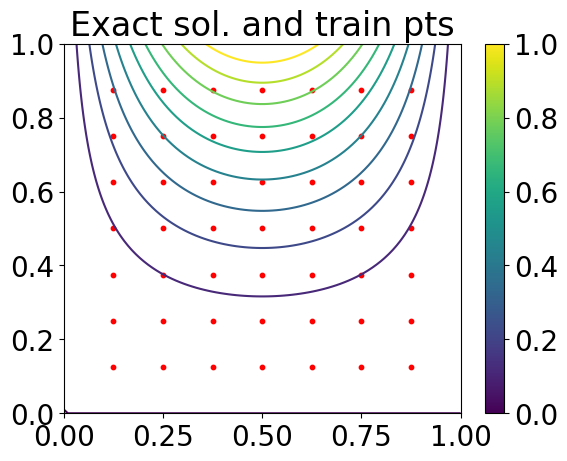

In [5]:
# define training points
npt1 = 9
strip_boundary = True
xtrain_grid, ytrain_grid, xytrain = prepare_data(0.,1.,npt1,0.,1.,npt1,strip_boundary)

# define test points
npt2 = 100
strip_boundary = False
xtest_grid, ytest_grid, xytest = prepare_data(0.,1.,npt2,0.,1.,npt2,strip_boundary)

# find the exact solution at the test points
sol_exact = ExactSolution(xtest_grid,ytest_grid)
sol_exact_vector = torch.reshape(sol_exact,(torch.numel(sol_exact),1))
sol_min = torch.min(sol_exact_vector)
sol_max = torch.max(sol_exact_vector)

# plot the exact solution and the training points
plt.figure()
plt.contour(xtest_grid,ytest_grid,sol_exact,torch.arange(sol_min,sol_max,(sol_max-sol_min)*0.1))  
plt.scatter(xytrain[:,0],xytrain[:,1],s = 10, c = '#FF0000')
plt.colorbar()
plt.title("Exact sol. and train pts")

In [6]:
# define activation function
def ActiveFun(x):
    # tanh
    ActFun = torch.tanh(x);
    dActFun = 1/torch.cosh(x).pow(2); # 1./cosh(x).^2
    d2ActFun = -2*torch.sinh(x)/torch.cosh(x).pow(3); # -2*sinh(x)./cosh(x).^3
    d3ActFun = (4*torch.sinh(x).pow(2)-2)/torch.cosh(x).pow(4); # (4*sinh(x).^2-2)./cosh(x).^4
    d4ActFun = 16*torch.tanh(x)/torch.cosh(x).pow(4) - 8*torch.tanh(x).pow(3)/torch.cosh(x).pow(2) # 16*tanh(x)/cosh(x)^4-8*tanh(x)^3/cosh(x)^2
    return ActFun, dActFun, d2ActFun, d3ActFun, d4ActFun

In [7]:
# define solution model
# define our model and call it model_11
N_neurons = 10
# initialize parameters of NN with random numbers
W = torch.rand(N_neurons*4,1)
# architecture: NN(X;w) = w3 * sigma(w0*x + w2*1 + w2)
# w3 is 1-by-N_neurons
# w2 is N_neurons-by-2
# w1 is Nneurons-by-1

def NeuralNetwork(x,y,W,derivatives):
    Nneurons = int((torch.numel(W)/4))
    # print("NN: Nneurons = ",Nneurons)
    W = torch.transpose(torch.reshape(W,(4,Nneurons)),0,1)
    z = W[:,2]+W[:,0]*x+W[:,1]*y # argument of sigma
    s0,s1,s2,s3,s4 = ActiveFun(z) # sigma(z) and its first three derivatives
    # the neural network and its derivatives with respect to x and y
    W3s1 = W[:,3]*s1
    W3s2 = W[:,3]*s2
    W3s3 = W[:,3]*s3
    W3s4 = W[:,3]*s4
    NN = torch.sum(W[:,3]*s0)
    if derivatives == False:
        return NN
    else:    
        NNx = torch.sum(W3s1*W[:,0])
        NNy = torch.sum(W3s1*W[:,1])
        NNxx = torch.sum(W[:,3]*(W[:,0].pow(2)*s2))
        NNyy = torch.sum(W[:,3]*(W[:,1].pow(2)*s2))
        # derivatives w.r.t. parameters of the neural network 
        NN_W0 = x*W3s1
        NN_W1 = y*W3s1
        NN_W2 = W3s1
        NN_W3 = s0
        NN_W = torch.cat((NN_W0,NN_W1,NN_W2,NN_W3),0) # combine derivatives into a column vector    
        # derivatives w.r.t. parameters of NNx = sum(w3*w0*s1)
        W3W0s2 = W[:,3]*W[:,0]*s2;
        NNx_W0 = W3s1 + W3W0s2*x
        NNx_W1 = W3W0s2*y
        NNx_W2 = W3W0s2
        NNx_W3 = W[:,0]*s1
        NNx_W = torch.cat((NNx_W0,NNx_W1,NNx_W2,NNx_W3),0) # combine derivatives into a column vector
        # derivatives w.r.t. parameters of NNy = sum(w3*w1*s1)
        W3W1s2 = W[:,3]*W[:,1]*s2;
        NNy_W0 = W3W1s2*x
        NNy_W1 = W3s1 + W3W1s2*y
        NNy_W2 = W3W1s2
        NNy_W3 = W[:,1]*s1
        NNy_W = torch.cat((NNy_W0,NNy_W1,NNy_W2,NNy_W3),0) # combine derivatives into a column vector
        # derivatives w.r.t. parameters of NNxx = sum(w3*w0^2*s2)
        W3W0W0s3 = W[:,3]*W[:,0].pow(2)*s3
        NNxx_W0 = 2*W3W0s2 + W3W0W0s3*x
        NNxx_W1 = W3W0W0s3*y
        NNxx_W2 = W3W0W0s3
        NNxx_W3 = W[:,0].pow(2)*s2
        NNxx_W = torch.cat((NNxx_W0,NNxx_W1,NNxx_W2,NNxx_W3),0) # combine derivatives into a column vector
        # derivatives w.r.t. parameters of NNyy = sum(w3*w1^2*s2)
        W3W1W1s3 = W[:,3]*W[:,1].pow(2)*s3
        NNyy_W0 = W3W1W1s3*x
        NNyy_W1 = 2*W3W1s2 + W3W1W1s3*y
        NNyy_W2 = W3W1W1s3
        NNyy_W3 = W[:,1].pow(2)*s2
        NNyy_W = torch.cat((NNyy_W0,NNyy_W1,NNyy_W2,NNyy_W3),0) # combine derivatives into a column vector
        
        # NNyx and NNyxx
        W0_sqW1 = W[:,0].pow(2)*W[:,1]
        W0W1 = W[:,0]*W[:,1]
        NNyx = torch.sum(W3s2*W0W1)
        NNyxx = torch.sum(W3s3*W0_sqW1)
        
        # NNyx_W
        W3s3W0W1 = W3s3*W0W1
        NNyx_W0 = x*W3s3W0W1
        NNyx_W1 = y*W3s3W0W1
        NNyx_W2 = W3s3W0W1
        NNyx_W3 = s2*W0W1
        NNyx_W = torch.cat((NNyx_W0,NNyx_W1,NNyx_W2,NNyx_W3),0) # combine derivatives into a column vector
        
        # NNyxx_W
        W3s4W0_sqW1 = W3s4*W0_sqW1
        NNyxx_W0 = x*W3s4W0_sqW1
        NNyxx_W1 = y*W3s4W0_sqW1
        NNyxx_W2 = W3s4W0_sqW1
        NNyxx_W3 = s3*W0_sqW1
        NNyxx_W = torch.cat((NNyxx_W0,NNyxx_W1,NNyxx_W2,NNyxx_W3),0) # combine derivatives into a column vector     
        
        return NN, NNx, NNy, NNxx, NNyy, NN_W, NNx_W, NNy_W, NNxx_W, NNyy_W, NNyx, NNyxx, NNyx_W, NNyxx_W
    
    
def SolutionModel(x,y,W):
    NN1, NN1x, NN1y, NN1xx, NN1yy, NN1_W, NN1x_W, NN1y_W, NN1xx_W, NN1yy_W, NN1yx, NN1yxx, NN1yx_W, NN1yxx_W = NeuralNetwork(x,y,W,True)
    NN2, NN2x, NN2y, NN2xx, NN2yy, NN2_W, NN2x_W, NN2y_W, NN2xx_W, NN2yy_W, NN2yx, NN2yxx, NN2yx_W, NN2yxx_W = NeuralNetwork(x,1,W,True)
    # u(x,y) = B(x,y) + x(1-x)y*NNT(x,y;W), where
    # B(x,y) = 2y\sin(\pi x)
    # "total" neural network NNT(x,y;W) = NN(x,y;W)-NN(x,1;W)-NN_y(x,1;W) = NN1-NN2-NN2y
    B = 2*y*torch.sin(torch.pi*x)
    C = x*(1-x)*y
    sol = B+C*(NN1-NN2-NN2y)
    return sol


def RHS(x,y):
    return (2-torch.pi**2*y**2)*torch.sin(torch.pi*x)


def PoissonEqSolutionModel(x,y,W):
    NN1, NN1x, NN1y, NN1xx, NN1yy, NN1_W, NN1x_W, NN1y_W, NN1xx_W, NN1yy_W, NN1yx, NN1yxx, NN1yx_W, NN1yxx_W = NeuralNetwork(x,y,W,True)
    NN2, NN2x, NN2y, NN2xx, NN2yy, NN2_W, NN2x_W, NN2y_W, NN2xx_W, NN2yy_W, NN2yx, NN2yxx, NN2yx_W, NN2yxx_W = NeuralNetwork(x,1,W,True)
    # computes r = Laplacian{B(x,y) + x(1-x)yNNT(x,y;W)} - RightHandSide
    # and the gradient of r w.r.t parameters W
    NNT = NN1-NN2-NN2y
    NNTx = NN1x-NN2x-NN2yx
    NNTy = NN1y
    NNTyy = NN1yy
    NNTxx = NN1xx-NN2xx-NN2yxx
    NNT_W = NN1_W-NN2_W-NN2y_W
    NNTx_W = NN1x_W-NN2x_W-NN2yx_W
    NNTy_W = NN1y_W
    NNTyy_W = NN1yy_W
    NNTxx_W = NN1xx_W-NN2xx_W-NN2yxx_W
    
    Bxx = -2*torch.pi**2*y*torch.sin(torch.pi*x)
    uxx = Bxx - 2*y*NNT + (1-2*x)*y*NNTx + x*(1-x)*y*NNTxx
    uyy = x*(1-x)*(2*NNTy + y*NNTyy)
    res = uxx + uyy - RHS(x,y)   
    dres_W = -2*y*NNT_W + (1-2*x)*y*NNTx_W + x*(1-x)*(2*NNTy_W + y*NNTyy_W + y*NNTxx_W)
    
    return res, dres_W

In [8]:
# form the vector of residuals and the Jacobian matrix for the set of training points
def Residual_and_Jacobian(xy,W):
    # each row of xy corresponds to a training point
    Nxy = xy.size(dim=0) # the number of training points
    NW = W.numel() # total number of entries of W
    res = torch.zeros(Nxy,1) # vector of residuals
    Jac = torch.zeros(Nxy,NW) # Jacobian matrix
    for j in range(Nxy):
        r,dr_W = PoissonEqSolutionModel(xy[j,0],xy[j,1],W)
        res[j] = r
        Jac[j,:] = dr_W
    return res, Jac    

In [9]:
# Levenverg-Marquardt
def Loss(r):
    return 0.5*torch.sum(r.pow(2)) # 0.5*sum(r^2)
    
    
def LevenbergMarquardt(Res_and_Jac,par,x):
    # minimizes loss = 0.5/n sum_{j=1}^n r_j^2(x)
    # constrained minimization problem solved at each step:
    # m(p) = grad^\top p + 0.5 p^\top Bmatr p --> min
    # subject to R - ||p|| >= 0
    # rho = [loss - loss(x + p)] / [loss - m(p)]
    
    # parameters for Levengerg-Marquardt
    RMAX = 1.;
    RMIN = 1e-12;
    RHO_GOOD = 0.75 # increase R is rho > RHO_GOOD
    RHO_BAD = 0.25 # decrease R is rho < RHO_BAD
    ETA = 0.01 # reject step if rho < ETA 
    ITER_MAX = 100
    TOL = 1.0e-3 # terminate when || grad loss || < tol
    
    # initialization
    r,J = Res_and_Jac(par,x)
    # print(r.size())
    # print(J.size())
    n = J.size(dim = 0) # the number of components of r
    d = J.size(dim = 1) # the number of variables
    lossvals = torch.zeros(ITER_MAX)
    gradnormvals = torch.zeros(ITER_MAX)
    lossvals[0] = Loss(r)
    Jtrans = torch.transpose(J,0,1)
    grad = torch.matmul(Jtrans,r) # grad = J^\top r
    Bmatr = torch.matmul(Jtrans,J) # Bmatr = J^\top J
    gradnorm = torch.linalg.norm(grad)
    gradnormvals[0] = gradnorm
    R = 0.2*RMAX # initial trust region radius
    print("iter 0: loss = ",lossvals[0]," gradnorm = ",gradnorm)
    # start iterations
    iter = 1
    while gradnorm > TOL and iter < ITER_MAX:
        # print(Jtrans.size())
        # print(J.size())
        # print(torch.eye(d).size())
        # print(torch.matmul(Jtrans,J).size())
        Bmatr = torch.matmul(Jtrans,J) # B = J^\top J
        p = -torch.linalg.lstsq(Bmatr,grad).solution # p = -Bmatr^{-1}grad
        norm_p = torch.linalg.norm(p)
        if norm_p > R:
            # solve grad^\top p + 0.5 p^\top Bmatr p --> min
            # subject to ||p|| = R
            gap = torch.abs(norm_p - R)
            iter_lam = 0
            lam_tol = 0.01*R
            lam = 1 # initial guess for lambda in the 1D constrained minimization problems
            while gap > lam_tol:
                B1 = Bmatr + lam*torch.eye(d) 
                C = torch.linalg.cholesky(B1) # B1 = C C^\top
                p = -torch.linalg.solve_triangular(torch.transpose(C,0,1), \
                     torch.linalg.solve_triangular(C,grad,upper = False),upper = True)
                norm_p = torch.linalg.norm(p)
                gap = torch.abs(norm_p - R)
                if gap > lam_tol:
                    q = torch.linalg.solve_triangular(C,p,upper = False)
                    norm_q = torch.linalg.norm(q)
                    lamnew = lam + (norm_p/norm_q).pow(2)*(norm_p-R)/R
                    if lamnew < 0:
                        lam = 0.5*lam
                    else:
                        lam = lamnew
                    iter_lam = iter_lam + 1
                    gap = torch.abs(norm_p - R)
            print("LM, iter ",iter,":", iter_lam," substeps")
        else:
            print("LM, iter ",iter,": steps to the model's minimum")
        # evaluate the progres
        # print("size of x: ",x.size())
        # print("size of p: ",p.size())
        xnew = x + p
        # print("size of xnew: ",xnew.size())
        rnew,Jnew = Res_and_Jac(par,xnew)  
        # print("rnew: ",rnew.size())
        # print("Jnew: ",Jnew.size())
        lossnew = Loss(rnew)
        rho = -(lossvals[iter-1] - lossnew)/(torch.sum(grad*p) + 0.5*sum(p*torch.matmul(Bmatr,p)))   
        # adjust the trust region radius
        if rho < RHO_BAD:
            R = torch.max(torch.tensor([RMIN,0.25*R]))
        elif rho > RHO_GOOD:
            R = torch.min(torch.tensor([RMAX,2.0*R]))                                       
        # accept or reject the step
        if rho > ETA:
            x = xnew
            r = rnew
            J = Jnew  
            Jtrans = torch.transpose(J,0,1)
            grad = torch.matmul(Jtrans,r)                                       
            gradnorm = torch.linalg.norm(grad)
        lossvals[iter] = lossnew
        gradnormvals[iter] = gradnorm
        print("LM, iter ",iter,": loss = ",lossvals[iter]," gradnorm = ",gradnorm," rho = ",rho," R = ",R)
        iter = iter + 1                                           
    return x,iter,lossvals[0:iter], gradnormvals[0:iter]                                                  

In [10]:
# test gradient
# dW = torch.zeros_like(W)
# delta = 1e-3
# jstar = 12
# dW[jstar] = 1
# # NN, NNx, NNy, NNxx, NNyy, NN_W, NNx_W, NNy_W, NNxx_W, NNyy_W = NeuralNetwork(xytrain[0,0],xytrain[0,1],W,True)
# # NN1, NNx1, NNy1, NNxx1, NNyy1, NN_W1, NNx_W1, NNy_W1, NNxx_W1, NNyy_W1 = NeuralNetwork(xytrain[0,0],xytrain[0,1],W+delta*dW,True)
# # NNm1, NNxm1, NNym1, NNxxm1, NNyym1, NN_Wm1, NNx_Wm1, NNy_Wm1, NNxx_Wm1, NNyy_Wm1 = NeuralNetwork(xytrain[0,0],xytrain[0,1],W-delta*dW,True)
# # print("NN: ",0.5*(NN1-NNm1)/delta," NN_W: ",NN_W[jstar])
# # print("NNx: ",0.5*(NNx1-NNxm1)/delta," NNx_W: ",NNx_W[jstar])
# # print("NNy: ",0.5*(NNy1-NNym1)/delta," NNy_W: ",NNy_W[jstar])
# # print("NNxx: ",0.5*(NNxx1-NNxxm1)/delta," NNxx_W: ",NNxx_W[jstar])
# # print("NNyy: ",0.5*(NNyy1-NNyym1)/delta," NNyy_W: ",NNyy_W[jstar])
# r,J = Residual_and_Jacobian(xytrain,W)
# r1,J1 = Residual_and_Jacobian(xytrain,W+delta*dW)
# rm1,Jm1 = Residual_and_Jacobian(xytrain,W-delta*dW)
# dr0 = 0.5*(r1-rm1)/delta
# print(dr0)
# print(J[:,jstar])


iter 0: loss =  tensor(833.3081)  gradnorm =  tensor(342.8150)
LM, iter  1 : 2  substeps
LM, iter  1 : loss =  tensor(761.7731)  gradnorm =  tensor(367.2233)  rho =  tensor([1.0643])  R =  tensor(0.4000)
LM, iter  2 : 3  substeps
LM, iter  2 : loss =  tensor(603.7429)  gradnorm =  tensor(417.2087)  rho =  tensor([1.1404])  R =  tensor(0.8000)
LM, iter  3 : 3  substeps
LM, iter  3 : loss =  tensor(273.1822)  gradnorm =  tensor(386.1688)  rho =  tensor([1.1850])  R =  tensor(1.)
LM, iter  4 : 4  substeps
LM, iter  4 : loss =  tensor(53.3637)  gradnorm =  tensor(50.0516)  rho =  tensor([1.1230])  R =  tensor(1.)
LM, iter  5 : 3  substeps
LM, iter  5 : loss =  tensor(10.7327)  gradnorm =  tensor(100.4353)  rho =  tensor([1.3689])  R =  tensor(1.)
LM, iter  6 : 2  substeps
LM, iter  6 : loss =  tensor(51.5462)  gradnorm =  tensor(100.4353)  rho =  tensor([-4.5253])  R =  tensor(0.2500)
LM, iter  7 : 3  substeps
LM, iter  7 : loss =  tensor(8.0516)  gradnorm =  tensor(46.0039)  rho =  tensor

LM, iter  60 : loss =  tensor(1.9687)  gradnorm =  tensor(3.1960)  rho =  tensor([0.4749])  R =  tensor(0.0625)
LM, iter  61 : 2  substeps
LM, iter  61 : loss =  tensor(1.9376)  gradnorm =  tensor(3.0673)  rho =  tensor([0.4714])  R =  tensor(0.0625)
LM, iter  62 : 2  substeps
LM, iter  62 : loss =  tensor(1.9077)  gradnorm =  tensor(2.9204)  rho =  tensor([0.4674])  R =  tensor(0.0625)
LM, iter  63 : 2  substeps
LM, iter  63 : loss =  tensor(1.8790)  gradnorm =  tensor(2.7724)  rho =  tensor([0.4643])  R =  tensor(0.0625)
LM, iter  64 : 2  substeps
LM, iter  64 : loss =  tensor(1.8513)  gradnorm =  tensor(2.6378)  rho =  tensor([0.4629])  R =  tensor(0.0625)
LM, iter  65 : 2  substeps
LM, iter  65 : loss =  tensor(1.8245)  gradnorm =  tensor(2.5251)  rho =  tensor([0.4638])  R =  tensor(0.0625)
LM, iter  66 : 2  substeps
LM, iter  66 : loss =  tensor(1.7984)  gradnorm =  tensor(2.4371)  rho =  tensor([0.4670])  R =  tensor(0.0625)
LM, iter  67 : 2  substeps
LM, iter  67 : loss =  tens

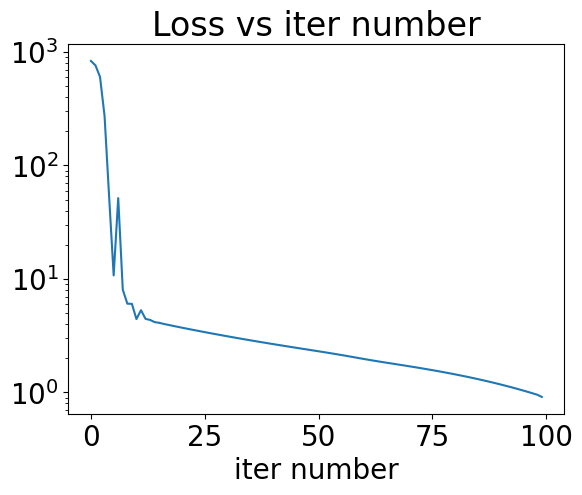

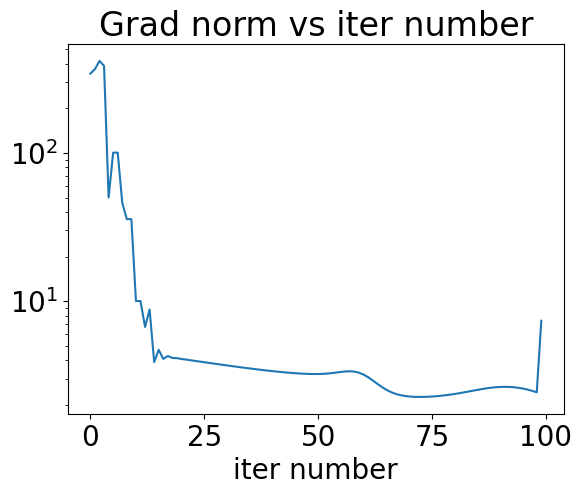

In [11]:
# train neural network
W,Niter,lossvals,gradnormvals = LevenbergMarquardt(Residual_and_Jacobian,xytrain,W)
# plot the loss and the norm of the gradient of the loss
plt.figure()
plt.plot(torch.arange(Niter),lossvals)
plt.title("Loss vs iter number")
plt.yscale("log")
plt.xlabel("iter number")
plt.savefig("hw9 loss.png")
plt.figure()
plt.plot(np.arange(Niter),gradnormvals)
plt.title("Grad norm vs iter number")
plt.yscale("log")
plt.xlabel("iter number")
plt.savefig("hw9 grad.png")

Max error =  tensor(0.0821)
Mean error =  tensor(0.0391)
RMS error =  tensor(0.0462)


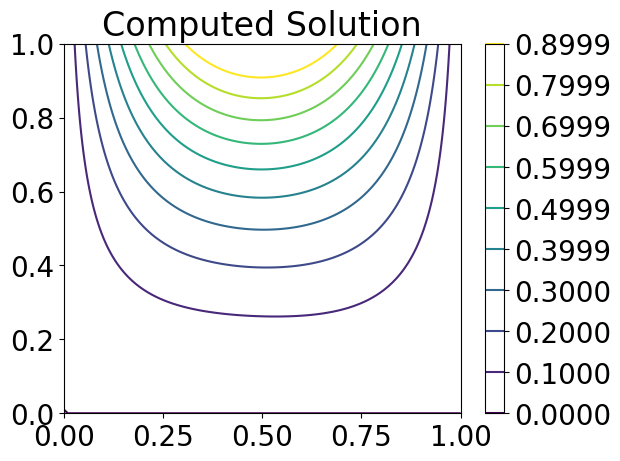

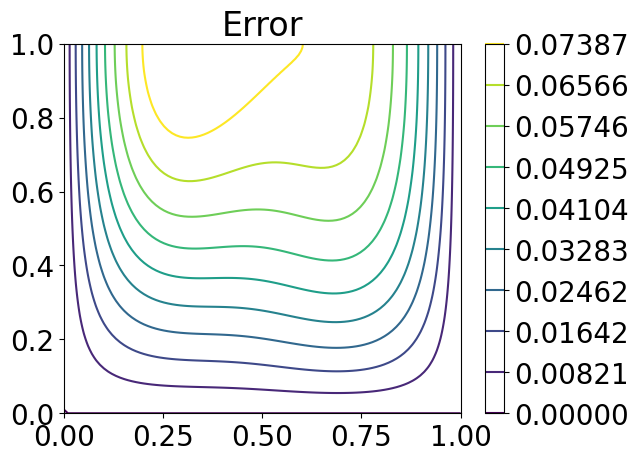

In [12]:
# test the solution
sol_test = torch.zeros(npt2,npt2)
Ntest = torch.numel(sol_test)
for i in range(npt2):
    for j in range(npt2):
        sol_test[i,j] = SolutionModel(xtest_grid[i,j],ytest_grid[i,j],W)
plt.figure()
plt.contour(xtest_grid,ytest_grid,sol_test,torch.arange(sol_min,sol_max,0.1*(sol_max-sol_min)))   
plt.colorbar()
plt.title("Computed Solution")
plt.savefig("hw9 sol.png")
# compare with the exact solution
error = torch.abs(sol_test - sol_exact)
error_vector = torch.reshape(error,(Ntest,1))
error_max = torch.max(error_vector)
plt.figure()
plt.contour(xtest_grid,ytest_grid,error,torch.arange(0.,error_max,error_max*0.1))  
plt.colorbar()
plt.title("Error")
plt.savefig("hw9 error.png")
print("Max error = ",torch.max(error_vector))
print("Mean error = ",torch.mean(error_vector))
print("RMS error = ",torch.sqrt(torch.mean(error_vector.pow(2))))